# Парная регрессионная модель зависимости заработной платы от возраста 
### (Нидерланды, 1987 г.)
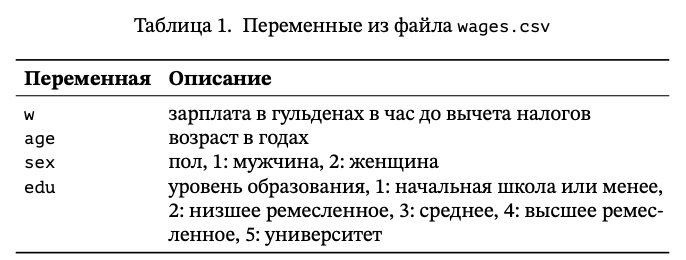

In [5]:
# imports
import numpy as np
import pandas as pd
import statsmodels.api as sm

# set pd/np parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)

#  plot imports
import matplotlib.pyplot as plt
import seaborn as sns

# set plt/sns parameters
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (15, 8)
sns.set_style("whitegrid")

### Загрузка данных

In [22]:
data = pd.read_csv('wages.csv')
print(data.head())

      w  sex  edu  age
0 10.44    1    1   19
1 13.52    1    1   20
2 19.12    1    1   21
3 20.28    1    1   25
4 14.63    1    1   26


### Таблица суммарных статистик переменных w и age

In [13]:
def calculate_summary_statistics(df, variables):
    summary_df = df[variables].describe().transpose().round(2)
    return summary_df

variables = ['w', 'age']
summary_stats = calculate_summary_statistics(data, variables)
summary_stats

,count,mean,std,min,25%,50%,75%,max
w,150.00,21.78,10.28,5.92,15.95,20.30,25.22,81.67
age,150.00,33.11,10.96,17.00,25.00,31.00,39.75,61.00


In [28]:
# библиотеки для создания экселя
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Border, Side

def save_summary_table_to_excel(summary_df, filename='summary_statistics.xlsx', title='Summary Statistics'):
    # cловарь для замены названий переменных
    column_names = {
        'w': 'зарплата (в гульденах в час до вычета налогов)',
        'age': 'возраст (возраст в годах)',
        'sex': 'пол',
        'edu': 'уровень образования',
        'log_w': 'log зарплаты',
        'log_age': 'log возраста'
    }
    renamed_df = summary_df.rename(index=column_names)
    
    # создаем новый Excel-файл и добавляем лист
    wb = Workbook()
    ws = wb.active
    ws.title = 'Statistics'

    # заголовок таблицы
    ws.append([title])
    ws["A1"].font = Font(bold=True, size=14)  # Жирный шрифт для заголовка
    ws.append([])  # Пустая строка для разделения заголовка и таблицы

    # добавляем строки из DataFrame в Excel-лист
    for r_idx, row in enumerate(dataframe_to_rows(renamed_df, index=True, header=True), start=3):
        ws.append(row)
        # Применяем границы только для строк таблицы (не затрагивая заголовок)
        if r_idx > 2: 
            for cell in ws[r_idx]:
                cell.border = Border(
                    left=Side(style='thin'),
                    right=Side(style='thin'),
                    top=Side(style='thin'),
                    bottom=Side(style='thin')
                )


    # сохранение файла
    wb.save(filename)
    print(f"Таблица сохранена в файл: {filename}")

save_summary_table_to_excel(summary_stats)

Таблица сохранена в файл: summary_statistics.xlsx


### log_w log_age суммарная статистика

In [32]:
data['log_w'] = np.log(data['w'])
data['log_age'] = np.log(data['age'])

summary_stats_4 = data[['w', 'age', 'log_w', 'log_age']].describe().transpose().round(2)

save_summary_table_to_excel(summary_stats_4, filename='summary_statistics_4.xlsx')
summary_stats_4

Таблица сохранена в файл: summary_statistics_4.xlsx


,count,mean,std,min,25%,50%,75%,max
w,150.00,21.78,10.28,5.92,15.95,20.30,25.22,81.67
age,150.00,33.11,10.96,17.00,25.00,31.00,39.75,61.00
log_w,150.00,2.99,0.43,1.78,2.77,3.01,3.23,4.40
log_age,150.00,3.45,0.32,2.83,3.22,3.43,3.68,4.11


In [13]:
save_summary_table_to_excel(summary_stats_4, filename='summary_statistics_4.xlsx', title='Summary Statistics 4 переменные')

Таблица сохранена в файл: summary_statistics_4.xlsx


### Построение четырех диаграмм рассеивания
Комментарий к увиденному: создается впечатление, что в диаграмме б) зависимость ближе всего к линейной. В диаграмме а) тоже похоже на линейную зависимость.

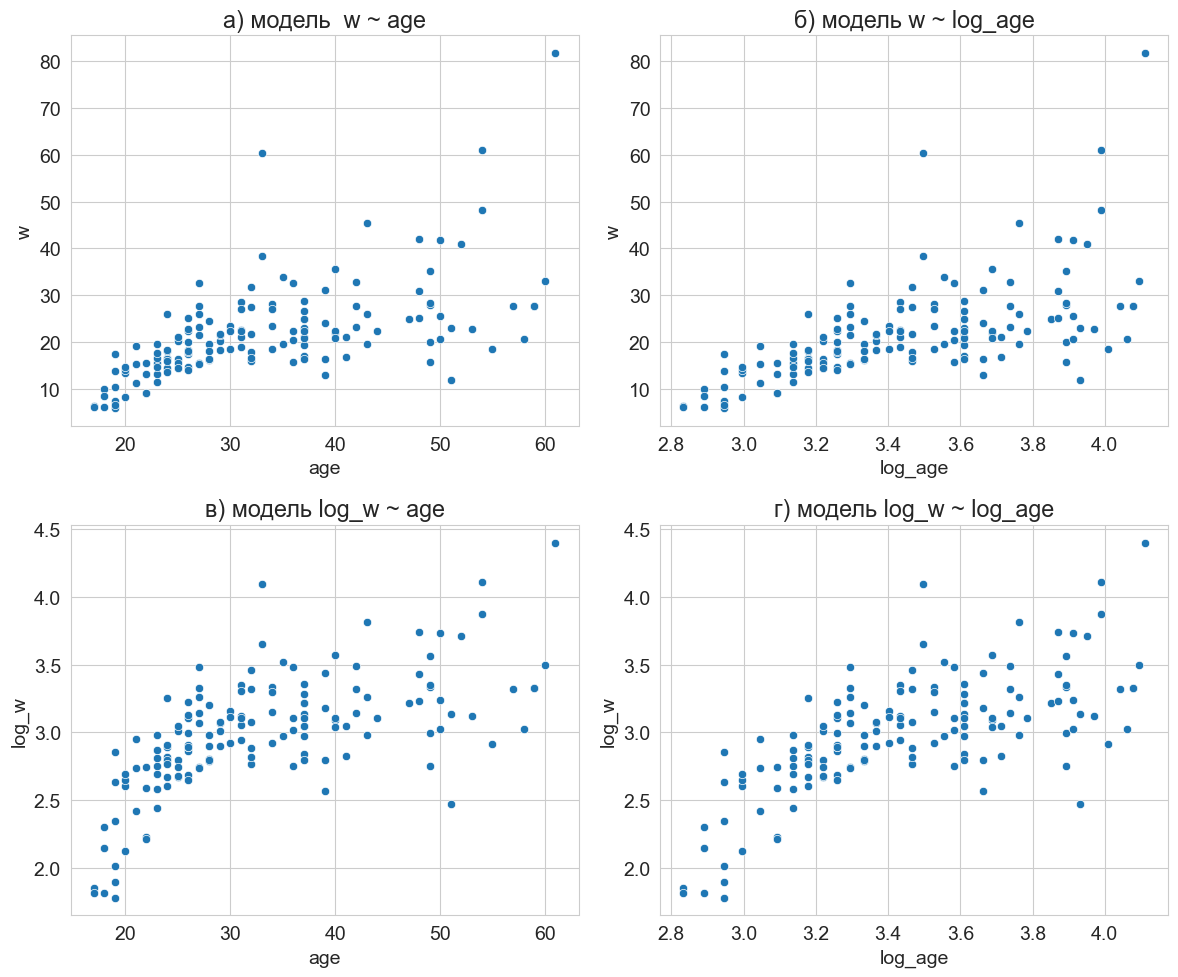

In [36]:
def save_scatter_plots(data, filename='scatter_plots.png'):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    sns.scatterplot(x='age', y='w', data=data, ax=axes[0, 0])
    axes[0, 0].set_title('а) модель  w ~ age')
    sns.scatterplot(x='log_age', y='w', data=data, ax=axes[0, 1])
    axes[0, 1].set_title('б) модель w ~ log_age')
    sns.scatterplot(x='age', y='log_w', data=data, ax=axes[1, 0])
    axes[1, 0].set_title('в) модель log_w ~ age')
    sns.scatterplot(x='log_age', y='log_w', data=data, ax=axes[1, 1])
    axes[1, 1].set_title('г) модель log_w ~ log_age')
    plt.tight_layout()
    plt.savefig(filename)

save_scatter_plots(data)
plt.show()

### Оценка линейной модели зависимости w от age
Предположения:
1. (xi, yi) - случайная выборка
2. Yi = b0 + b1Xi + ei, E(ei|Xi) = 0 (линейное приближение)
3. Хi не все одинаковые
4. Существует 4 момент
Также делаем предположение о гетероскедастичности данных

In [40]:
Y = data['w']
X = sm.add_constant(data[['age']])

model_w_age = sm.OLS(Y, X).fit(cov_type='HC0') #heteroscedasticity robust covariance
print (model_w_age.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     34.36
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           2.87e-08
Time:                        18:33:59   Log-Likelihood:                -528.04
No. Observations:                 150   AIC:                             1060.
Df Residuals:                     148   BIC:                             1066.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0678      2.804      1.094      0.2

### Регрессия w на log_age

In [44]:
X_log_age = sm.add_constant(data['log_age'])
model_w_log_age = sm.OLS(Y, X_log_age).fit(cov_type='HC0')
print(model_w_log_age.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     46.96
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           1.82e-10
Time:                        18:34:38   Log-Likelihood:                -526.51
No. Observations:                 150   AIC:                             1057.
Df Residuals:                     148   BIC:                             1063.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -45.6593      9.378     -4.869      0.0

### Регрессия log_w на age

In [48]:
Y_log_w = data['log_w']
model_log_w_age = sm.OLS(Y_log_w, X).fit(cov_type='HC0')
print(model_log_w_age.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_w   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     67.36
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           1.02e-13
Time:                        18:35:03   Log-Likelihood:                -47.498
No. Observations:                 150   AIC:                             99.00
Df Residuals:                     148   BIC:                             105.0
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1443      0.105     20.518      0.0

### Регрессия log_w на log_age

In [51]:
model_log_w_log_age = sm.OLS(Y_log_w, X_log_age).fit(cov_type='HC0')
print(model_log_w_log_age.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_w   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     88.72
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           8.52e-17
Time:                        18:35:44   Log-Likelihood:                -38.910
No. Observations:                 150   AIC:                             81.82
Df Residuals:                     148   BIC:                             87.84
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2213      0.339     -0.653      0.5

In [56]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


### Сохранение в таблицу результатов всех регрессий

In [61]:
def save_regression_results(results, filename):
    # Названия моделей
    model_names = ['зарплата ~ возраст', 'log зарплаты ~ возраст', 'зарплата ~ log возраста', 'log зарплаты ~ log возраста']
    data = {}

    # Сбор данных по каждой модели
    for model_name, result in zip(model_names, results):
        params = result.params
        conf = result.bse
        pvalues = result.pvalues
        r2 = result.rsquared
        nobs = int(result.nobs)

        # Форматируем коэффициенты, ошибки и значимость
        model_data = {}
        for var in ['const', 'age', 'log_age']:
            if var in params:
                signif = '***' if pvalues[var] < 0.01 else ('**' if pvalues[var] < 0.05 else ('*' if pvalues[var] < 0.1 else ''))
                model_data[var] = f'{params[var]:.3f}{signif} ({conf[var]:.3f})'
            else:
                model_data[var] = '-'

        # Добавляем R^2 и число наблюдений
        model_data['R^2'] = f'{r2:.3f}'
        model_data['Число наблюдений'] = f'{nobs}'

        # Сохраняем данные модели
        data[model_name] = model_data

    # Преобразуем данные в DataFrame и транспонируем
    df = pd.DataFrame(data)
    df = df.rename(index={
        'age': 'возраст',
        'log_age': 'log возраста',
        'const': 'константа',
        'R^2': 'R^2',
        'Число наблюдений': 'Число наблюдений'
    })

    # Создаем Excel
    wb = Workbook()
    ws = wb.active
    ws.title = 'Regression Results'

    # Заголовок таблицы
    ws.append(['Результаты регрессионного анализа'])
    ws['A1'].font = Font(bold=True, size=14)
    ws.append([])  # Пустая строка для разделения заголовка и таблицы

    # Добавляем данные из DataFrame в таблицу Excel
    ws.append(['Переменная'] + list(df.columns))  # Заголовок таблицы
    for row in df.itertuples(index=True):
        ws.append([row.Index] + list(row[1:]))

    # Применяем стили и границы
    for r_idx, row in enumerate(ws.iter_rows(min_row=3, max_row=ws.max_row, min_col=1, max_col=len(df.columns) + 1), start=3):
        for cell in row:
            cell.border = Border(
                left=Side(style='thin'),
                right=Side(style='thin'),
                top=Side(style='thin'),
                bottom=Side(style='thin')
            )

    # Настраиваем ширину столбцов
    ws.column_dimensions['A'].width = 35
    for col_idx in range(2, len(df.columns) + 2):
        col_letter = ws.cell(row=3, column=col_idx).column_letter
        ws.column_dimensions[col_letter].width = 20

    # Сохраняем файл
    wb.save(filename)
    print(f'Таблица сохранена в файл: {filename}')

save_regression_results(
    [model_w_age, model_log_w_age, model_w_log_age, model_log_w_log_age],
    'regression_results_.xlsx'
)

Таблица сохранена в файл: regression_results_.xlsx


### Диаграмма рассеивания и линия регрессии для модели зарплата ~ log возраста

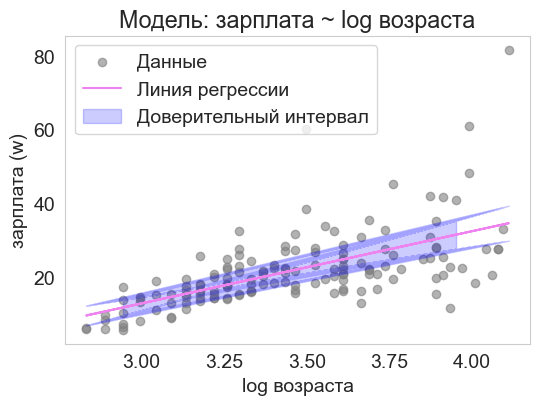

In [63]:
X_log_age = sm.add_constant(data[['log_age']])  # Добавляем константу к признакам

# Получение предсказаний и доверительных интервалов
pred = model_w_log_age.get_prediction(X_log_age)
mean_pred = pred.summary_frame()['mean']
ci_lower = pred.summary_frame()['mean_ci_lower']
ci_upper = pred.summary_frame()['mean_ci_upper']

# Построение графика
plt.figure(figsize=(6, 4))
plt.scatter(data['log_age'], data['w'], color='gray', alpha=0.6, label='Данные')
plt.plot(data['log_age'], mean_pred, color='violet', label='Линия регрессии')
plt.fill_between(data['log_age'], ci_lower, ci_upper, color='blue', alpha=0.2, label='Доверительный интервал')
plt.xlabel('log возраста')
plt.ylabel('зарплата (w)')
plt.title('Модель: зарплата ~ log возраста')
plt.legend()
plt.grid()
plt.savefig('best_model_w_log_age.png')
plt.show()

### Четыре модели раздельно для мужчин и для женщин

In [67]:
# Разделение данных по полу
data_men = data[data['sex'] == 1]
data_women = data[data['sex'] == 2]

# Суммарные статистики для мужчин и женщин
variables = ['w', 'age', 'log_w', 'log_age']
summary_stats_men = calculate_summary_statistics(data_men, variables)
summary_stats_women = calculate_summary_statistics(data_women, variables)

save_summary_table_to_excel(summary_stats_men, filename='summary_statistics_men.xlsx', title='Summary Statistics (Men)')
save_summary_table_to_excel(summary_stats_women, filename='summary_statistics_women.xlsx', title='Summary Statistics (Women)')

Таблица сохранена в файл: summary_statistics_men.xlsx
Таблица сохранена в файл: summary_statistics_women.xlsx


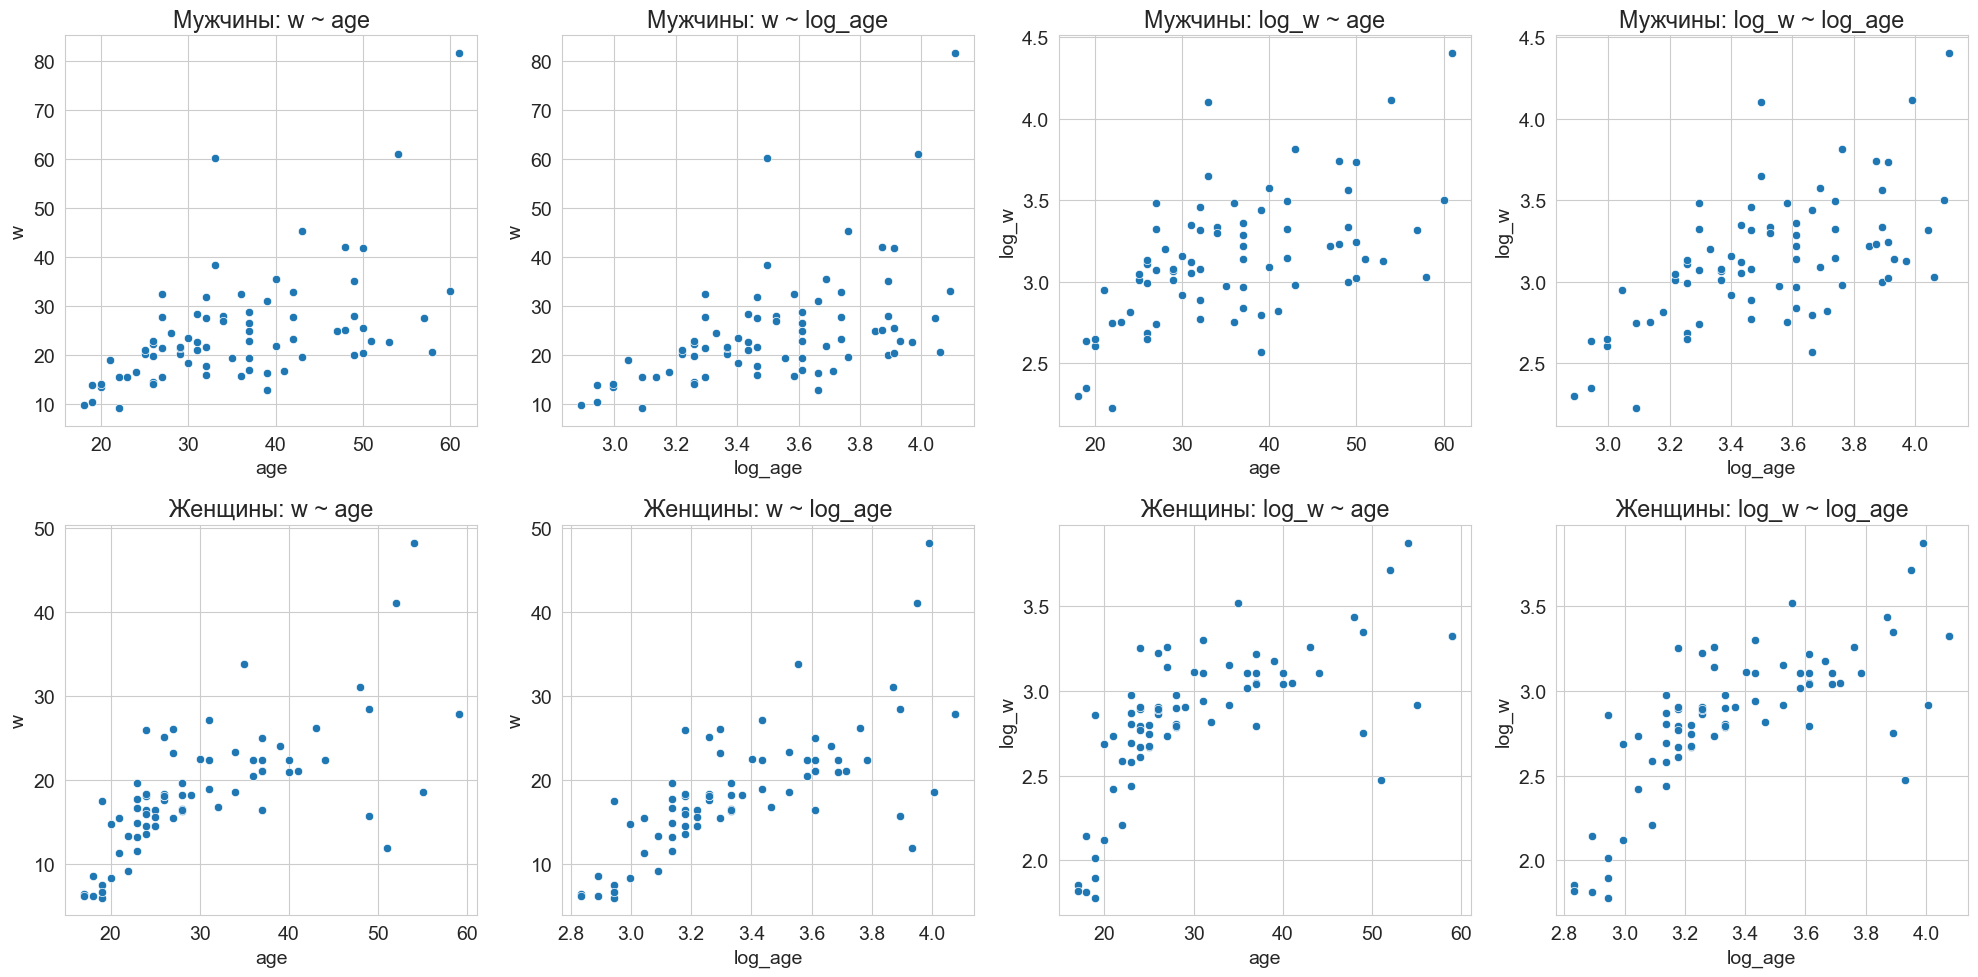

In [69]:
# Шаг 2: Функция для построения диаграмм рассеивания по группам
def save_scatter_plots_by_gender(data_men, data_women, filename='scatter_plots_by_gender.png'):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Мужчины
    sns.scatterplot(x='age', y='w', data=data_men, ax=axes[0, 0])
    axes[0, 0].set_title('Мужчины: w ~ age')
    sns.scatterplot(x='log_age', y='w', data=data_men, ax=axes[0, 1])
    axes[0, 1].set_title('Мужчины: w ~ log_age')
    sns.scatterplot(x='age', y='log_w', data=data_men, ax=axes[0, 2])
    axes[0, 2].set_title('Мужчины: log_w ~ age')
    sns.scatterplot(x='log_age', y='log_w', data=data_men, ax=axes[0, 3])
    axes[0, 3].set_title('Мужчины: log_w ~ log_age')

    # Женщины
    sns.scatterplot(x='age', y='w', data=data_women, ax=axes[1, 0])
    axes[1, 0].set_title('Женщины: w ~ age')
    sns.scatterplot(x='log_age', y='w', data=data_women, ax=axes[1, 1])
    axes[1, 1].set_title('Женщины: w ~ log_age')
    sns.scatterplot(x='age', y='log_w', data=data_women, ax=axes[1, 2])
    axes[1, 2].set_title('Женщины: log_w ~ age')
    sns.scatterplot(x='log_age', y='log_w', data=data_women, ax=axes[1, 3])
    axes[1, 3].set_title('Женщины: log_w ~ log_age')

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

save_scatter_plots_by_gender(data_men, data_women)

In [71]:
# Функция для регрессий по группам
def regress_and_print(data, name):
    print(f"\nРезультаты регрессий для группы: {name}\n")

    # Модель w ~ age
    Y = data['w']
    X = sm.add_constant(data[['age']])
    model_w_age = sm.OLS(Y, X).fit(cov_type='HC0')
    print("w ~ age")
    print(model_w_age.summary())

    # Модель w ~ log_age
    X_log_age = sm.add_constant(data[['log_age']])
    model_w_log_age = sm.OLS(Y, X_log_age).fit(cov_type='HC0')
    print("w ~ log_age")
    print(model_w_log_age.summary())

    # Модель log_w ~ age
    Y_log_w = data['log_w']
    model_log_w_age = sm.OLS(Y_log_w, X).fit(cov_type='HC0')
    print("log_w ~ age")
    print(model_log_w_age.summary())

    # Модель log_w ~ log_age
    model_log_w_log_age = sm.OLS(Y_log_w, X_log_age).fit(cov_type='HC0')
    print("log_w ~ log_age")
    print(model_log_w_log_age.summary())

In [73]:
regress_and_print(data_women, "Женщины")


Результаты регрессий для группы: Женщины

w ~ age
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     26.83
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           1.89e-06
Time:                        18:40:03   Log-Likelihood:                -233.03
No. Observations:                  75   AIC:                             470.1
Df Residuals:                      73   BIC:                             474.7
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [75]:
regress_and_print(data_men, "Мужчины")


Результаты регрессий для группы: Мужчины

w ~ age
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     12.96
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           0.000577
Time:                        18:40:06   Log-Likelihood:                -278.31
No. Observations:                  75   AIC:                             560.6
Df Residuals:                      73   BIC:                             565.3
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c